In [17]:
library(rhdf5)
library(Rhdf5lib)
library(MOFA2)
library(reticulate)
library(ggplot2)
library(ggthemes)

In [3]:
#use_condaenv("mypy3")
use_python("/nfs/software/stegle/users/acuomo/conda-envs/mypy3/bin/python", required=TRUE)
reticulate::py_config()

python:         /nfs/software/stegle/users/acuomo/conda-envs/mypy3/bin/python
libpython:      /nfs/software/stegle/users/acuomo/conda-envs/mypy3/lib/libpython3.6m.so
pythonhome:     /nfs/software/stegle/users/acuomo/conda-envs/mypy3:/nfs/software/stegle/users/acuomo/conda-envs/mypy3
version:        3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31)  [GCC 7.3.0]
numpy:          /homes/acuomo/.local/lib/python3.6/site-packages/numpy
numpy_version:  1.18.1

NOTE: Python version was forced by use_python function

In [6]:
sce = readRDS("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/endodiff_clean.rds")
sce

class: SingleCellExperiment 
dim: 11231 34256 
metadata(4): log.exprs.offset log.exprs.offset log.exprs.offset
  log.exprs.offset
assays(3): tpm counts logcounts
rownames(11231): ENSG00000000003_TSPAN6 ENSG00000000419_DPM1 ...
  ENSG00000272325_NUDT3 ENSG00000272398_CD24
rowData names(17): exprs_collapsed_to ensembl_transcript_id ...
  is_intop2000hvg is_hvg
colnames(34256): 21843_1#10 21843_1#100 ... 24539_8#97 24539_8#98
colData names(123): adj_x adj_y ... princ_curve princ_curve_scaled01
reducedDimNames(1): PCA
spikeNames(1): ERCC
altExpNames(0):

In [33]:
df_pca = as.data.frame(prcomp(t(logcounts(sce[rowData(sce)$is_intop500hvg,])))$x[,1:50])

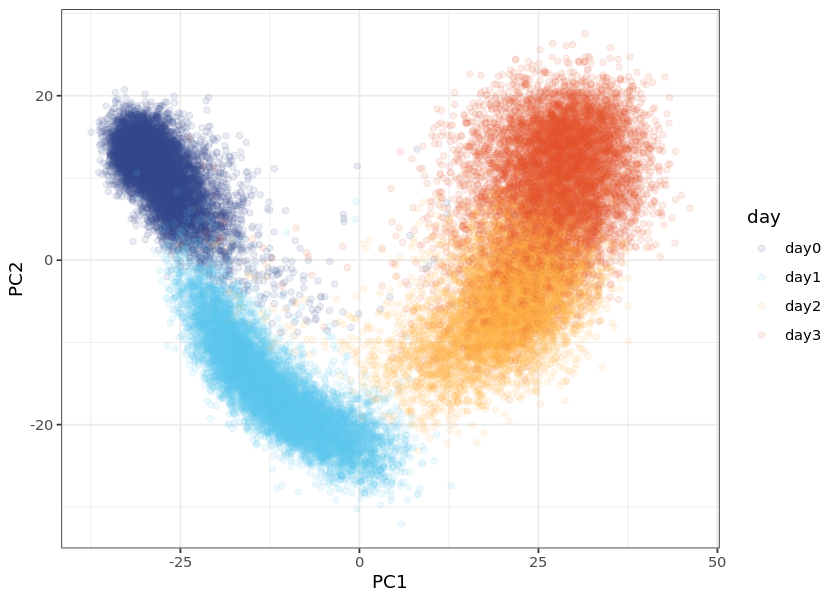

In [36]:
options(repr.plot.width = 7, repr.plot.height = 5)
df_pca$day = sce$day
p = ggplot(df_pca, aes(x = PC1, y = PC2, col = day)) + geom_point(alpha = 0.1) + theme_bw()
p = p + scale_color_canva(palette = "Pool party") 
p

In [37]:
data = list(scRNAseq = logcounts(sce[rowData(sce)$is_intop500hvg,]))
MOFAobject <- create_mofa(data)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...

No groups provided as argument... we assume that all samples are coming from the same group.



In [38]:
data_opts <- get_default_data_options(MOFAobject)
# data_opts$use_float32 <- TRUE # next time run like this to be faster

In [39]:
model_opts <- get_default_model_options(MOFAobject)
model_opts

$likelihoods
  scRNAseq 
"gaussian" 

$num_factors
[1] 15

$spikeslab_factors
[1] FALSE

$spikeslab_weights
[1] TRUE

$ard_factors
[1] FALSE

$ard_weights
[1] TRUE

In [40]:
model_opts$num_factors <- 20
model_opts$spikeslab_weights <- FALSE

In [41]:
train_opts <- get_default_training_options(MOFAobject)
train_opts$convergence_mode <- "medium"
train_opts$seed <- 42

In [42]:
#########################
## Prepare MOFA object ##
#########################

MOFAobject <- prepare_mofa(MOFAobject,
  data_options = data_opts,
  model_options = model_opts,
  training_options = train_opts
  # stochastic_options = stochastic_opts
)

Checking data options...
Checking training options...
Checking model options...


In [43]:
#####################
## Train the model ##
#####################

outfile <- "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/mofa_logcounts_model.hdf5"
MOFAmodel <- run_mofa(MOFAobject, outfile)

ERROR: Error: Unable to read dataset.
Not all required filters available.
Missing filters: deflate
